In [167]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from warnings import filterwarnings
filterwarnings("ignore")


from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
path = "/content/drive/MyDrive/Self_Driving_Car/Image/test_image.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [169]:
def display(image):

    plt.figure(figsize = (15,7))
    plt.imshow(image, cmap = "gray")
    plt.title(f"Shape : {image.shape}")
    plt.show()

def count_display(image):
    plt.figure(figsize = (35,7))
    sns.countplot(pd.Series(image.ravel()))
    plt.title("Count Pixel")
    plt.xticks(rotation = 90)
    plt.show()

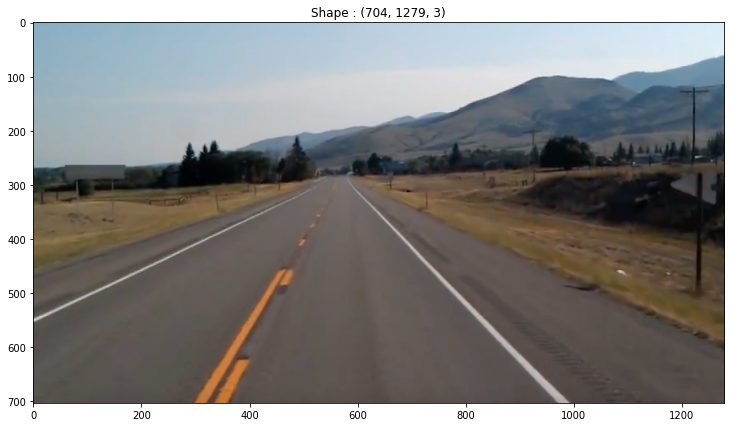

In [170]:
display(image)

# Convert Gray

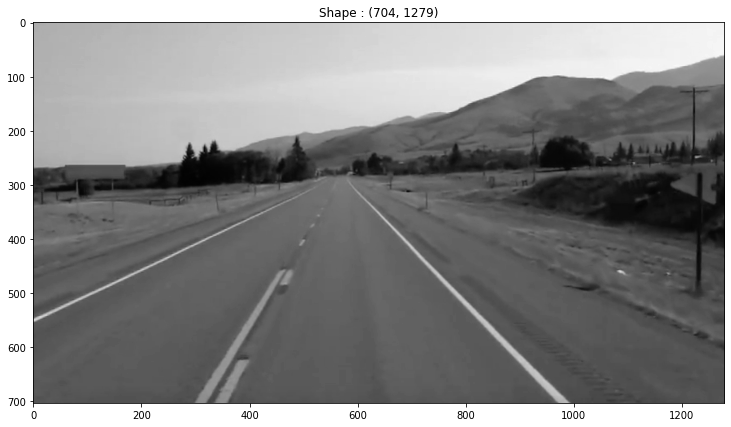

In [171]:
lane_image = np.copy(image)
gray_image = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

display(gray_image)

In [172]:
gray_image.max(),gray_image.min()

(244, 0)

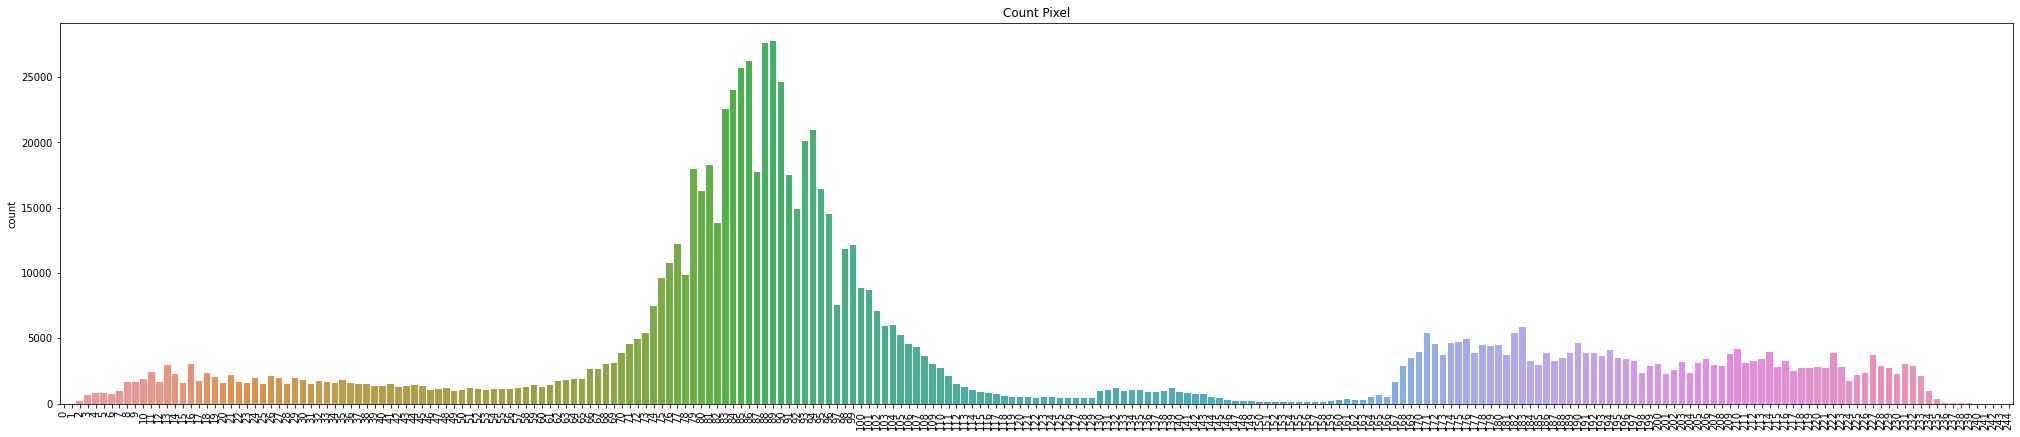

In [173]:
count_display(gray_image)

# Smoothening Image

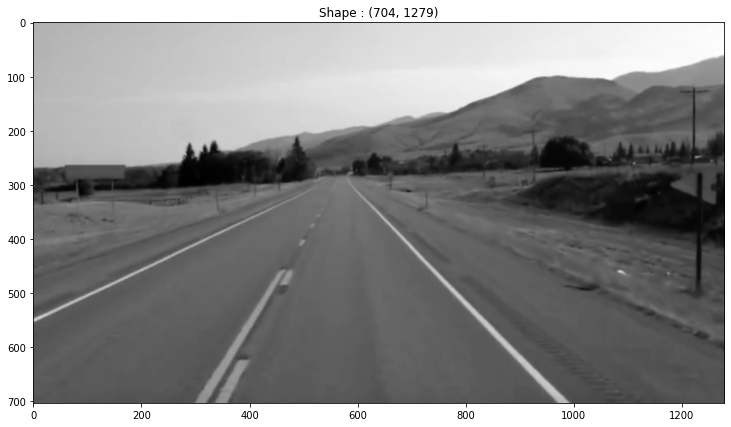

In [174]:
blur_image = cv2.GaussianBlur(gray_image,ksize = (5,5),sigmaX = 0)

display(blur_image)

In [175]:
# Gray ile arasındaki farkı gördün mü ?
blur_image.max(),blur_image.min()

(237, 2)

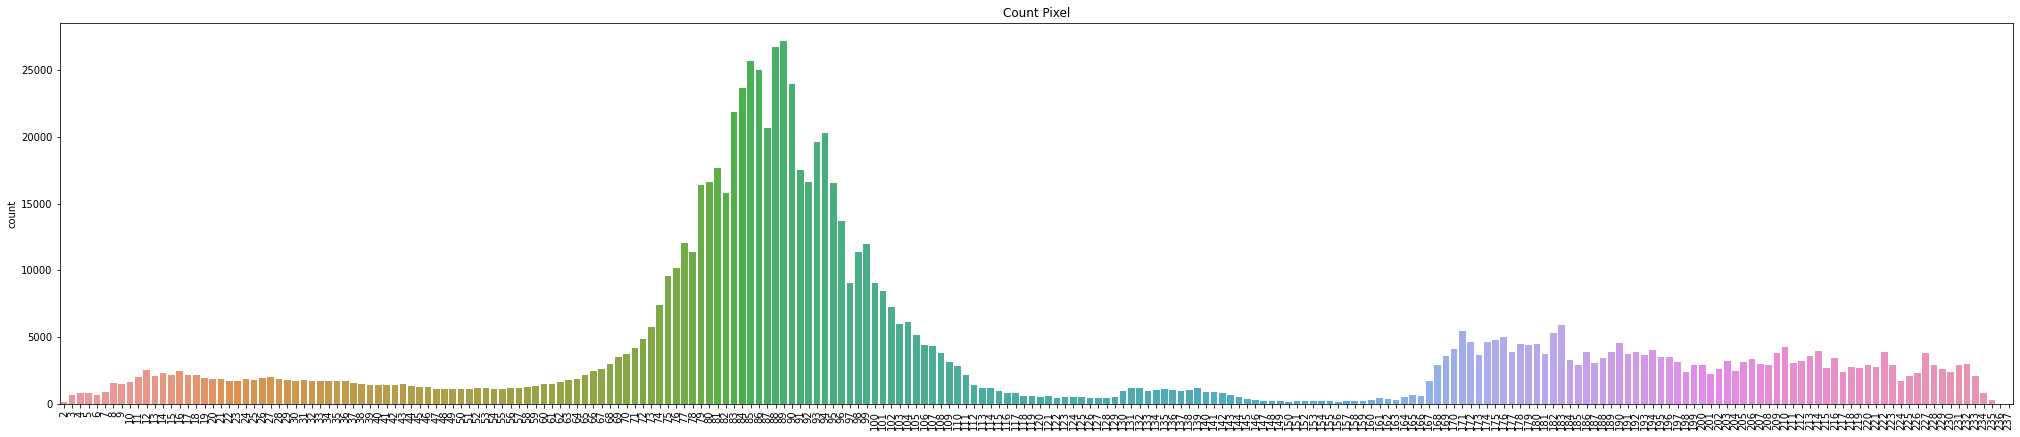

In [176]:
count_display(blur_image)

# Simple Edge Detection

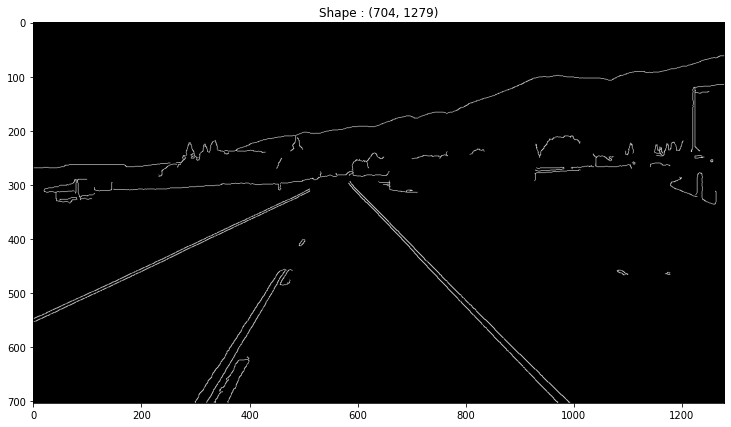

In [177]:
canny_image = cv2.Canny(blur_image,50,150)

display(canny_image)

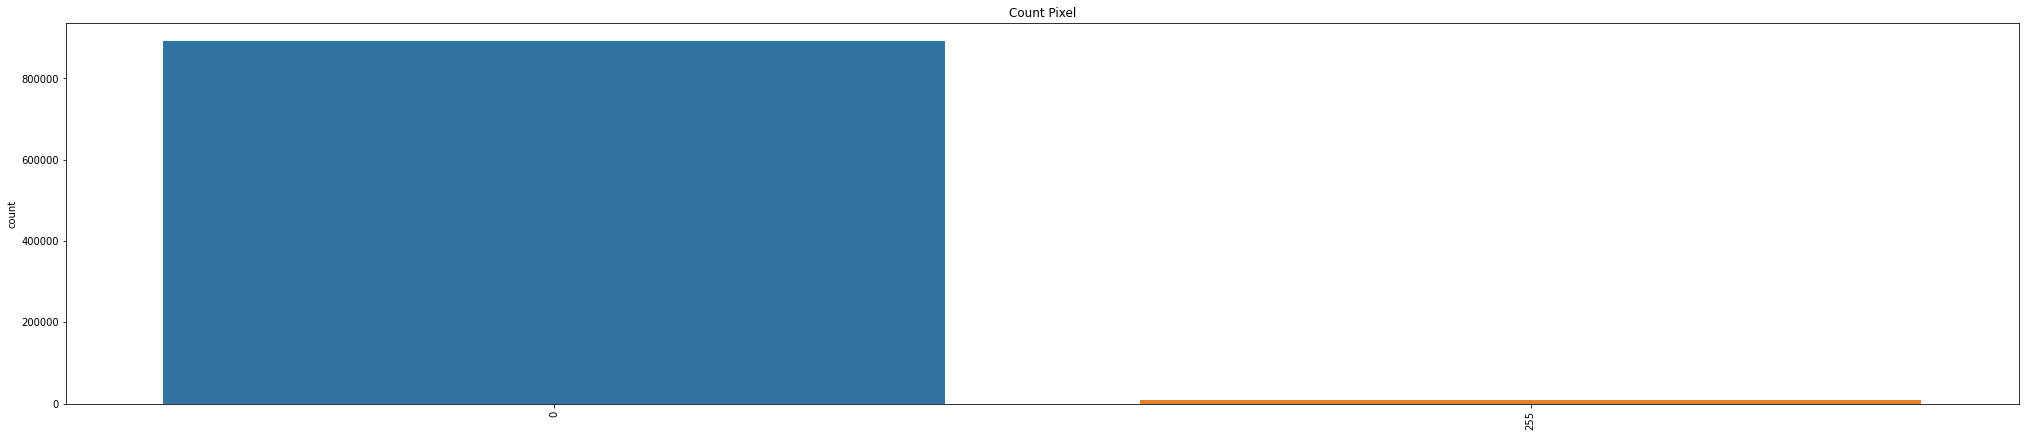

In [178]:
count_display(canny_image)

# Region of Interest

In [179]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def canny_conv(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (5,5),0)
    canny_img = cv2.Canny(blur_img,50,150)
    return canny_img

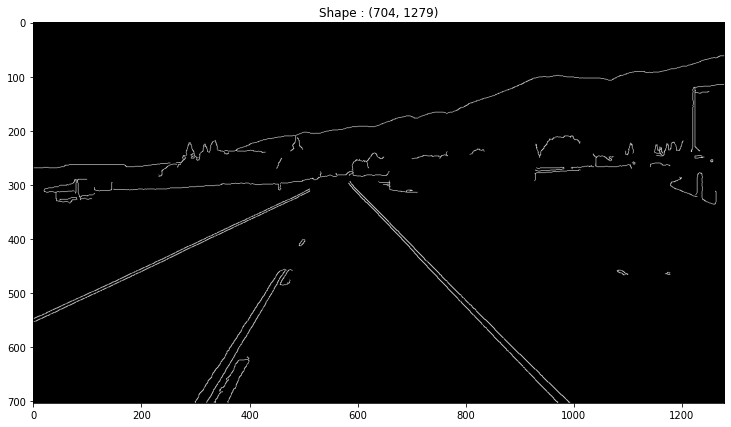

In [180]:
canny = canny_conv(image)
display(canny)

In [181]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([(200,height), ( 1100, height) , (550, 250)])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [triangle],(255,255,255))
    return mask

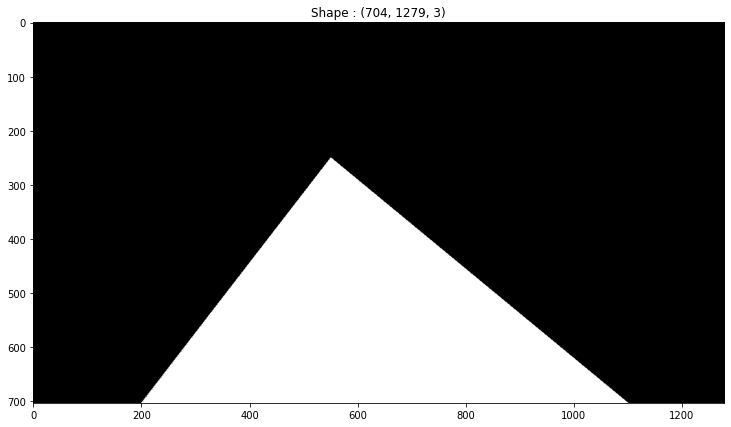

In [182]:
roi = region_of_interest(image)
display(roi)

# Bitwise_And

In [183]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([(200,height), ( 1100, height) , (550, 250)])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [triangle],(255,255,255))
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

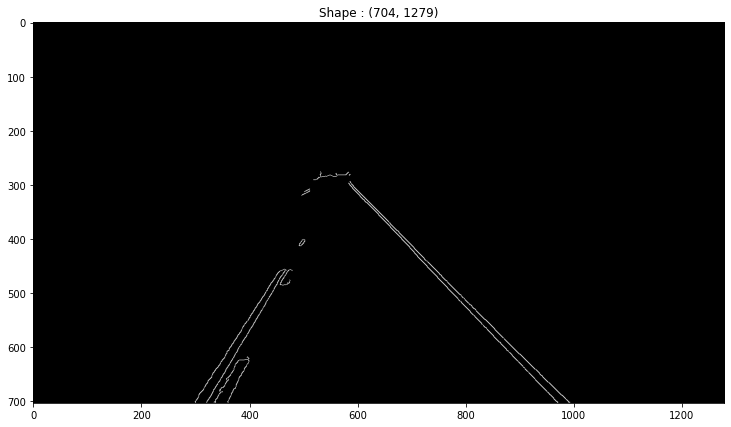

In [184]:
# Dağlık olan kısımlar mask da 0 olduğu için her türlü yutucak
# Ama Yolu belirlemiş olduğumuz üçgende orası ne gelirse gelsin aynı o bölge neyi içeriyorsa o gelicek !!!

# Üçgen içindeki değerler için bu örnek !!!
# örnek1 :1111 Bu mask
# örnek2 :1100 Bu canny
# Sonuç  :1100 Bu da sonuç

cropped_image = region_of_interest(canny)

display(cropped_image)

# Hough Transfrom - Line Detection

In [185]:
np.pi / 180

0.017453292519943295

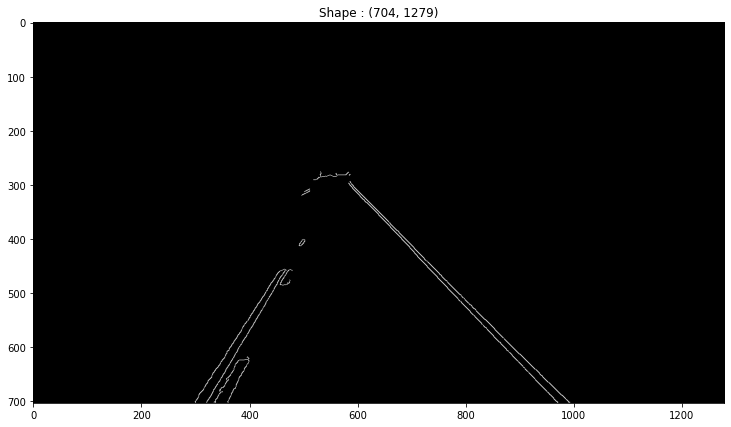

In [186]:
display(cropped_image)

In [187]:
def display_lines(image,lines):

    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            # print(line)
            line = line.reshape(4)
            # print(line)
            x1,y1,x2,y2 = line
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)

    return line_image

In [188]:
lines = cv2.HoughLinesP(image = cropped_image,rho = 2,theta = np.pi / 180 ,threshold = 100,lines = np.array([]),minLineLength = 40,maxLineGap =5)

lane_image = np.copy(image)
lines_image = display_lines(lane_image, lines)

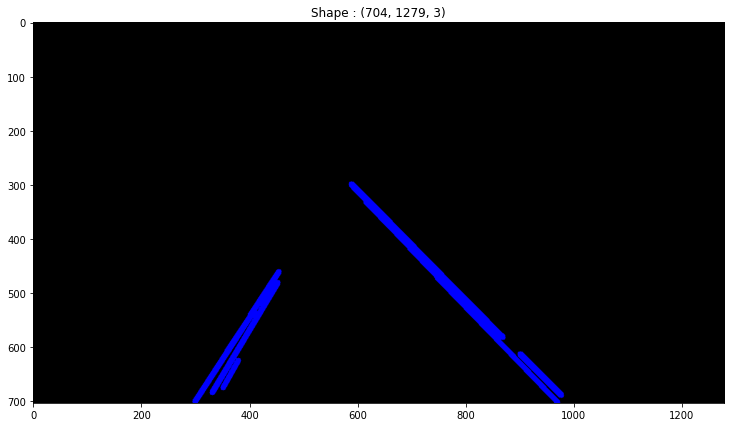

In [189]:
display(lines_image)

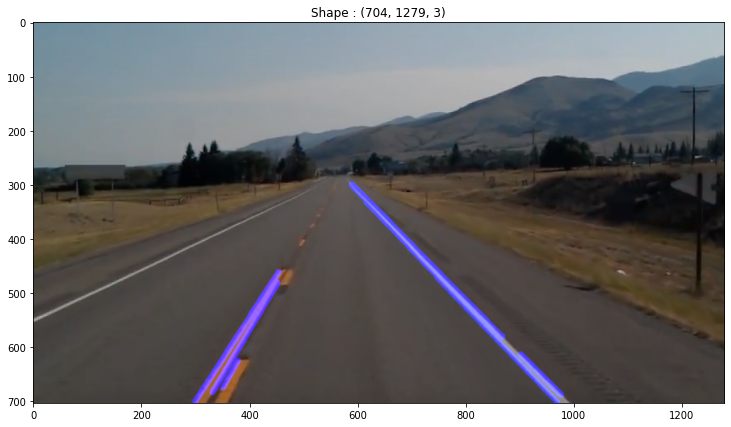

In [190]:
combo_image = cv2.addWeighted(lane_image,0.8, lines_image, 1, 1)
display(combo_image)

# Optimizing

In [204]:
def make_coordinates(image, line_parameters):

    slope, intercept = line_parameters
    #print(image.shape)
    y1 = image.shape[0]
    y2 = int(y1*(3/5))

    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    return np.array([x1,y1,x2,y2])

In [205]:
# Burda şimdi y ekseni aşağı doğru giderken artarken
# Yukarı doğru çıkarken azalıyor
# Bildiğimiz slope hesaplama yanı fakat
# Left_Fit Azalıyorken
# Right_Fit Artıyor!! 
# Ayrıma dikkat et !!!

def average_slope_intercept(image, lines):

    left_fit = []
    right_fit = []
    if lines is None:
        return None

    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        #print(parameters)
        if slope < 0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))

    #print(left_fit)
    #print(right_fit)
    if len(left_fit) and len(right_fit):
        
        left_fit_average = np.average(left_fit, axis = 0)
        right_fit_average = np.average(right_fit, axis = 0)
        #print(left_fit_average)
        #print(right_fit_average)
        left_line = make_coordinates(image,left_fit_average)
        right_line = make_coordinates(image, right_fit_average)
        return np.array([left_line,right_line])

In [206]:
lane_image = np.copy(image)
average_slope_intercept(lane_image, lines)

array([[332, 704, 491, 422],
       [999, 704, 710, 422]])

In [207]:
print(np.average(np.array([(-1.540229885057473, 1161.5287356321846), (-1.677685950413222, 1239.3140495867763)]), axis = 1),
np.average(np.array([(-1.540229885057473, 1161.5287356321846), (-1.677685950413222, 1239.3140495867763)]), axis = 0),
(-1.540229885057473+ 1161.5287356321846) / 2,(-1.540229885057473 + -1.677685950413222) / 2)

[579.99425287 618.81818182] [  -1.60895792 1200.42139261] 579.9942528735636 -1.6089579177353475


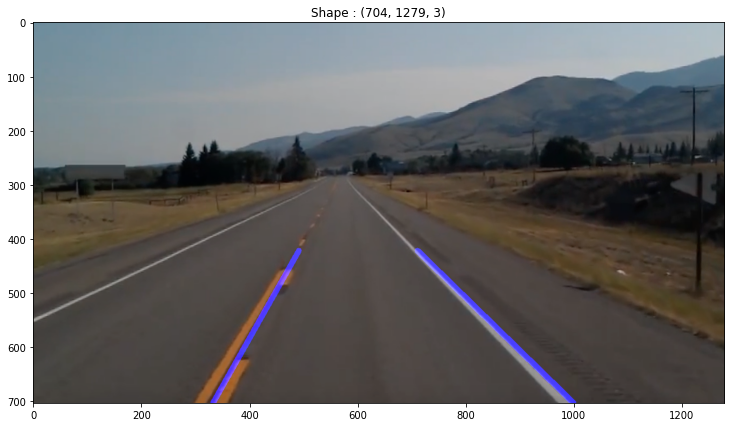

In [208]:
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
display(combo_image)

# Finding Lanes On Video

In [209]:
video_path = "/content/drive/MyDrive/Self_Driving_Car/Image/test2.mp4"
cap = cv2.VideoCapture(video_path)

while (cap.isOpened()):

    conn, frame = cap.read()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    canny_image = canny_conv(frame)
    cropped_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, np.array([]), 40,5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8 , line_image, 1,1)

    display(combo_image)

cap.release()
writer.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.